In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import numpy as np
from waymo_open_dataset import dataset_pb2 as open_dataset
import matplotlib.pyplot as plt
import dask.dataframe as dd
import tensorflow as tf
from waymo_open_dataset import v2
import time
from typing import Any, Dict, Iterator, List, Optional, Sequence, Tuple
from waymo_open_dataset.utils import camera_segmentation_utils

tf.compat.v1.enable_eager_execution()


camera_name_list = {
   1 : "FRONT",
   2 : "FRONT_LEFT",
   3 : "FRONT_RIGHT",
   4 : "SIDE_LEFT",
   5 : "SIDE_RIGHT"
}
class PanopticSegmentationDataset(Dataset):
    def __init__(self, frames_path, labels_path, frames_id_list_path, datasetNum, transform=None):
        self.frames_path = frames_path
        self.labels_path = labels_path
        self.frames_context_dict = self.get_frames_context_dict(frames_id_list_path, datasetNum)
        self.transform = transform
        
        # see how is self.frames_context_dict structured:
        print("Data imported:")
        for key in (self.frames_context_dict):
            for timestamp in self.frames_context_dict[key]:
                print("context_name: ", key, "Timestamp: ", timestamp)
        
        self.frames_list = [] # a list, each item is a list[(img1, "FRONT"), ..., (img5, "SIDE_RIGHT")] at one time step
        self.labels_list = [] # a list, each item is a list[[img1_label_semantic, img1_label_instance, img1_panoptic_label, "FRONT"], ..., (img5_label_semantic, img5_label_instance, "SIDE_RIGHT")] at one time step
        end  = 0
        start = 0
        for context_name in self.frames_context_dict:
            print(end-start, "s, importing ", context_name)
            start = time.time()
            self.load_frames_from_parquet(context_name, self.frames_context_dict[context_name])
            self.load_labels_from_parquet(context_name, self.frames_context_dict[context_name])
            end = time.time()
        print(len(self.frames_list))
        print(len(self.labels_list))
        assert(len(self.frames_list) == len(self.labels_list)) # the number of timestamps should match
        
        
    def __len__(self):
        return len(self.frames_list)
    
    def __getitem__(self, index):
        """
        get a frame (containing multiple cameras) for one time step
        """
        frames = self.frames_list[index]# a list of tuple:(rgb input images, camera_num): [(img1, FRONT), (img2, FRONT_LEFT),...,(img5, SIDE_RIGHT)]
        labels = self.labels_list[index]# a list of 3-tems:(semantic_labels, instance_labels, camera_num):
        
        # apply transform
        if self.transform:
            frames = [(self.transform(img), camera_name) for (img, camera_name) in frames]  
            labels = [(self.transform(semantic_label), self.transform(instance_label), self.transform(panoptic_label), camera_name) for (semantic_label, instance_label, panoptic_label, camera_name) in labels]
        
        return frames, labels
    
    def load_frames_from_parquet(self, context_name, desired_time_stamp_list):
        """
        Given context name and time_stamp, fetch parquet file, filter with desired timestamp
        
        In theory, in the filtered df, for each unique timestamp, there's 5 images corresponding to 5 cameras
        
        for each unique timestamp, append a list[(img1, "FRONT"), ..., (img5, "SIDE_RIGHT")] to self.frames_list
        
        """
        camera_image_df = dd.read_parquet(tf.io.gfile.glob(f'{self.frames_path}/{context_name}.parquet'))
        filtered_camera_image_df = camera_image_df[camera_image_df['key.frame_timestamp_micros'].isin(desired_time_stamp_list)]
        frames_for_one_timestamp = []
        collected_cameras = [] # to determine if we need to move on and wrap next timestamp
        for i, (key_values, row) in enumerate(filtered_camera_image_df.iterrows()):
            # every iteration here has the same context name, and each iteration is a desired timestamp (each desired timstamp has multiple cameras)
            camera_image = v2.CameraImageComponent.from_dict(row)
            data_time_stamp = camera_image.key.frame_timestamp_micros
            camera_name = camera_name_list[camera_image.key.camera_name]
            if(camera_name in collected_cameras):
                # Then it means we've moved on to next timestamp
                # sort camera_num
                frames_for_one_timestamp = sorted(frames_for_one_timestamp, key=lambda frames_for_one_timestamp: frames_for_one_timestamp[1])
                frames_for_one_timestamp = [(image, camera_name_list[camera_num]) for (image, camera_num) in frames_for_one_timestamp]
                self.frames_list.append(frames_for_one_timestamp)
                frames_for_one_timestamp = []
                collected_cameras = []
            image = tf.image.decode_jpeg(camera_image.image)
            image = image.numpy()
            image = np.int32(image)
            collected_cameras.append(camera_name)
            frames_for_one_timestamp.append((image, camera_image.key.camera_name))
        
        # The end, append last set
        frames_for_one_timestamp = sorted(frames_for_one_timestamp, key=lambda frames_for_one_timestamp: frames_for_one_timestamp[1])
        frames_for_one_timestamp = [(image, camera_name_list[camera_num]) for (image, camera_num) in frames_for_one_timestamp]
        self.frames_list.append(frames_for_one_timestamp)
            
    
    def load_labels_from_parquet(self, context_name, desired_time_stamp_list):
        """
        Given context name and time_stamp, fetch parquet file, filter with timestamp
        In theory, in the filtered df, for each unique timestamp, there's 5 camera seg component
        we decode those camera seg component,
        
        and for each timestamp, append a list to self.labels_list 
        each item is a list[[img1_label_semantic, img1_label_instance, img1_panoptic_label "FRONT"], ..., (img5_label_semantic, img5_label_instance, img5_panoptic_label "SIDE_RIGHT")] at one time step
        
        """
        cam_segmentation_df = dd.read_parquet(tf.io.gfile.glob(f'{self.labels_path}/{context_name}.parquet'))
        filtered_camera_seg_df = cam_segmentation_df[cam_segmentation_df['key.frame_timestamp_micros'].isin(desired_time_stamp_list)]
        frame_keys = ['key.segment_context_name', 'key.frame_timestamp_micros']
        cam_segmentation_per_frame_df = filtered_camera_seg_df.groupby(frame_keys, group_keys=False).agg(list)
        # Group segmentation labels into frames by context name and timestamp.

        def ungroup_row(key_names: Sequence[str],
                        key_values: Sequence[str],
                        row: dd.DataFrame) -> Iterator[Dict[str, Any]]:
            """Splits a group of dataframes into individual dicts."""
            keys = dict(zip(key_names, key_values))
            cols, cells = list(zip(*[(col, cell) for col, cell in r.items()]))
            for values in zip(*cells):
                yield dict(zip(cols, values), **keys)

        cam_segmentation_list = []
        for i, (key_values, r) in enumerate(cam_segmentation_per_frame_df.iterrows()):
            # Store a segmentation label component for each camera.
            # each iteration: a timestamp
            cam_segmentation_list.append(
              [v2.CameraSegmentationLabelComponent.from_dict(d) 
               for d in ungroup_row(frame_keys, key_values, r)])
        camera_num_order = [open_dataset.CameraName.FRONT,
                          open_dataset.CameraName.FRONT_LEFT,
                          open_dataset.CameraName.FRONT_RIGHT,
                          open_dataset.CameraName.SIDE_LEFT,
                          open_dataset.CameraName.SIDE_RIGHT]
        segmentation_protos_ordered = []
        for it, label_list in enumerate(cam_segmentation_list):
            segmentation_dict = {label.key.camera_name: label for label in label_list}
            segmentation_protos_ordered.append([segmentation_dict[name] for name in camera_num_order])
        segmentation_protos_flat = sum(segmentation_protos_ordered, [])
        panoptic_labels, num_cameras_covered, is_tracked_masks, panoptic_label_divisor = camera_segmentation_utils.decode_multi_frame_panoptic_labels_from_segmentation_labels(
            segmentation_protos_flat, remap_to_global=True
        )
        NUM_CAMERA_FRAMES = 5
        for i in range(0, len(segmentation_protos_flat), NUM_CAMERA_FRAMES):
            labels = []
            for j in range(NUM_CAMERA_FRAMES):
                semantic_label, instance_label = camera_segmentation_utils.decode_semantic_and_instance_labels_from_panoptic_label(panoptic_labels[i + j], panoptic_label_divisor)
                panoptic_label_rgb = camera_segmentation_utils.panoptic_label_to_rgb(semantic_label, instance_label)
                semantic_label = np.int32(semantic_label)
                instance_label = np.int32(instance_label)
                panoptic_label_rgb = np.int32(panoptic_label_rgb)
                labels.append([semantic_label, instance_label, panoptic_label_rgb, camera_name_list[j+1]])
            self.labels_list.append(labels)
            
    
    def get_frames_context_dict(self, txtFile, datasetNum):
        """
        input: txt file provided by Waymo

        output: a dictionary = {
            context_name1 : [timestamp1, timestamp2, ...],
            context_name2 : [timestamp1],
            ...
        } 
        """
        list_ = open(txtFile).read().split()
        list_ = sorted(list_, key=lambda list_: list_[1])
        frames_context_dict = {}
        cutoff = datasetNum
        if(datasetNum == None):
            cutoff = len(list_)
        else:
            cutoff = datasetNum
        for i, line in enumerate(list_):
            if(i >= cutoff):
                break
            frames_line = line.split(',')
            context_name, time_stamp = frames_line
            if context_name in frames_context_dict:
                frames_context_dict[context_name].append(int(time_stamp))
            else:
                frames_context_dict[context_name] = [int(time_stamp)]
        return frames_context_dict

2023-04-15 00:50:49.119992: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-15 00:50:49.579949: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-04-15 00:50:51.024590: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/ros/foxy/opt/yaml_cpp_vendor/lib:/opt/ros/foxy/opt/rviz_ogre_vendor/lib:/opt/ros/f

In [2]:
train_transform = transforms.Compose([
    transforms.ToTensor()
])
batch_size = 32
datasetNum = 10
frames_path = "/media/kaiwenjon/Kevin-linux-dats/waymo/dataset_v2/training/camera_image"
labels_path = "/media/kaiwenjon/Kevin-linux-dats/waymo/dataset_v2/training/camera_segmentation"
frames_id_list_path = "./2d_pvps_training_frames.txt"
dataset = PanopticSegmentationDataset(frames_path, labels_path, frames_id_list_path, datasetNum, transform=train_transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size)

Data imported:
context_name:  10017090168044687777_6380_000_6400_000 Timestamp:  1550083469645130
context_name:  10017090168044687777_6380_000_6400_000 Timestamp:  1550083470045260
context_name:  10017090168044687777_6380_000_6400_000 Timestamp:  1550083470245288
context_name:  10017090168044687777_6380_000_6400_000 Timestamp:  1550083470445324
context_name:  10017090168044687777_6380_000_6400_000 Timestamp:  1550083470845389
context_name:  10017090168044687777_6380_000_6400_000 Timestamp:  1550083474648906
context_name:  10017090168044687777_6380_000_6400_000 Timestamp:  1550083475049006
context_name:  10017090168044687777_6380_000_6400_000 Timestamp:  1550083475249048
context_name:  10017090168044687777_6380_000_6400_000 Timestamp:  1550083475449087
context_name:  10017090168044687777_6380_000_6400_000 Timestamp:  1550083475849035
0 s, importing  10017090168044687777_6380_000_6400_000


2023-04-15 00:50:53.605284: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-15 00:50:53.977129: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-15 00:50:53.977558: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-15 00:50:53.982256: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operati

10
10


In [3]:
for batch_idx, (frames, labels) in enumerate(dataloader):
    # data format
    # frames: a list[FRONT_list, FRONT_LEFT_list, FRONT_RIGHT_list, SIDE_LEFT_list, SIDERIGHT_list]
    # frames[0]: FRONT_list: a list[FRONT_TENSOR, CameraNameTuple]
    # frames[0][0]: FRONT_TENSOR: torch.Size([batch_size, 3, 1280, 1920])
    # frames[0][1]: CameraNameTuple: ('FRONT', 'FRONT', 'FRONT', ....(batch_size)), in theory they should all be the same

    # labels: a list[FRONT_list, FRONT_LEFT_list, FRONT_RIGHT_list, SIDE_LEFT_list, SIDERIGHT_list]
    # labels[0]: FRONT_list: a list[FRONT_semantic_label_tensor, FRONT_instance_label_tensor, panoptic_label_tensor, CameraNameTuple]
    # labels[0][0]: FRONT_semantic_label_tensor: torch.Size([batch_size, 1, 1280, 1920])
    # labels[0][1]: FRONT_instance_label_tensor: torch.Size([batch_size, 1, 1280, 1920])
    # labels[0][2]: FRONT_panoptic_rgb_label_tensor: torch.Size([batch_size, 3, 1280, 1920])
    # labels[0][3]: CameraNameTuple: ('FRONT', 'FRONT', 'FRONT', ....(batch_size)), in theory they should all be the same
    for i in camera_name_list:
        cameraTupleFrame = frames[i-1][1]
        cameraTupleLabel = labels[i-1][2]
        assert all(element == cameraTupleFrame[0] for element in cameraTupleFrame)
        assert all(element == cameraTupleLabel[0] for element in cameraTupleLabel)
        assert cameraTupleFrame[0] == camera_name_list[i]
        assert cameraTupleLabel[0] == camera_name_list[i]
    
    # torch.Size([batch_size, 3, 1280, 1920])
    imgs_FRONT = frames[0][1]
    imgs_FRONT_LEFT = frames[1][1]
    imgs_FRONT_RIGHT = frames[2][1]
    imgs_SIDE_LEFT = frames[3][1]
    imgs_SIDE_RIGHT = frames[4][1]
    
    # torch.Size([batch_size, 1, 1280, 1920])
    semantic_labels_FRONT = labels[0][0]
    semantic_labels_FRONT_LEFT = labels[1][0]
    semantic_labels_FRONT_RIGHT = labels[2][0]
    semantic_labels_SIDE_LEFT = labels[3][0]
    semantic_labels_SIDE_RIGHT = labels[4][0]
    
    # torch.Size([batch_size, 1, 1280, 1920])
    instance_labels_FRONT = labels[0][1]
    instance_labels_FRONT_LEFT = labels[1][1]
    instance_labels_FRONT_RIGHT = labels[2][1]
    instance_labels_SIDE_LEFT = labels[3][1]
    instance_labels_SIDE_RIGHT = labels[4][1]
    
    # torch.Size([batch_size, 3, 1280, 1920])
    panoptic_rgb_labels_FRONT = labels[0][2]
    panoptic_rgb_labels_FRONT_LEFT = labels[1][2]
    panoptic_rgb_labels_FRONT_RIGHT = labels[2][2]
    panoptic_rgb_labels_SIDE_LEFT = labels[3][2]
    panoptic_rgb_labels_SIDE_RIGHT = labels[4][2]
    
    plt.figure(figsize=(64, 60))
    plt.imshow(panoptic_label_rgb)
    plt.grid(False)
    plt.axis('off')
    plt.show()
    
    

torch.Size([10, 3, 1280, 1920])


In [3]:
test_transform = transforms.Compose([
    transforms.ToTensor()
])
datasetNum = None
frames_path = "/media/kaiwenjon/Kevin-linux-dats/waymo/dataset_v2/testing_location/camera_image"
labels_path = "/media/kaiwenjon/Kevin-linux-dats/waymo/dataset_v2/testing_location/camera_segmentation"
frames_id_list_path = "./2d_pvps_test_frames.txt"
dataset = PanopticSegmentationDataset(frames_path, labels_path, frames_id_list_path, datasetNum, transform=test_transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=1)

0 s, Adding  10149575340910243572_2720_000_2740_000


2023-04-14 22:40:36.864392: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-14 22:40:37.207355: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-14 22:40:37.207761: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-04-14 22:40:37.208818: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operati

IndexError: list index out of range

In [ ]:
validation_transform = transforms.Compose([
    transforms.ToTensor()
])
datasetNum = None
frames_path = "/media/kaiwenjon/Kevin-linux-dats/waymo/dataset_v2/validation/camera_image"
labels_path = "/media/kaiwenjon/Kevin-linux-dats/waymo/dataset_v2/validation/camera_segmentation"
frames_id_list_path = "./2d_pvps_validation_frames.txt"
dataset = PanopticSegmentationDataset(frames_path, labels_path, frames_id_list_path, datasetNum, transform=validation_transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=1)

0 s, Adding  1024360143612057520_3580_000_3600_000


Loaded image (430782 bytes) for camera_image.key.camera_name=1 1553628864248893 camera_image.key.camera_name=1


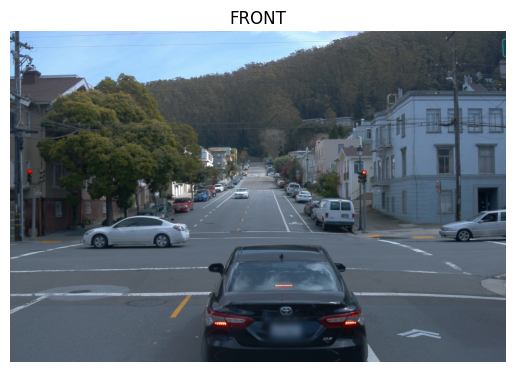

0
Loaded image (456226 bytes) for camera_image.key.camera_name=2 1553628864248893 camera_image.key.camera_name=2
Loaded image (310542 bytes) for camera_image.key.camera_name=4 1553628864248893 camera_image.key.camera_name=4
Loaded image (341771 bytes) for camera_image.key.camera_name=3 1553628864248893 camera_image.key.camera_name=3
Loaded image (194267 bytes) for camera_image.key.camera_name=5 1553628864248893 camera_image.key.camera_name=5
Loaded image (431692 bytes) for camera_image.key.camera_name=1 1553628864348883 camera_image.key.camera_name=1
Loaded image (456370 bytes) for camera_image.key.camera_name=2 1553628864348883 camera_image.key.camera_name=2
Loaded image (310632 bytes) for camera_image.key.camera_name=4 1553628864348883 camera_image.key.camera_name=4
Loaded image (341943 bytes) for camera_image.key.camera_name=3 1553628864348883 camera_image.key.camera_name=3
Loaded image (194525 bytes) for camera_image.key.camera_name=5 1553628864348883 camera_image.key.camera_name=5

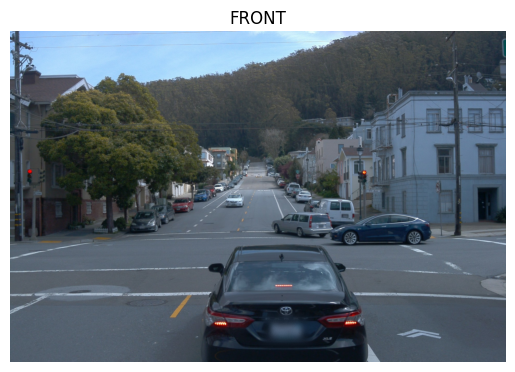

100
Loaded image (455528 bytes) for camera_image.key.camera_name=2 1553628866248862 camera_image.key.camera_name=2
Loaded image (310601 bytes) for camera_image.key.camera_name=4 1553628866248862 camera_image.key.camera_name=4
Loaded image (341349 bytes) for camera_image.key.camera_name=3 1553628866248862 camera_image.key.camera_name=3
Loaded image (194588 bytes) for camera_image.key.camera_name=5 1553628866248862 camera_image.key.camera_name=5
Loaded image (428832 bytes) for camera_image.key.camera_name=1 1553628866348889 camera_image.key.camera_name=1
Loaded image (455872 bytes) for camera_image.key.camera_name=2 1553628866348889 camera_image.key.camera_name=2
Loaded image (310946 bytes) for camera_image.key.camera_name=4 1553628866348889 camera_image.key.camera_name=4
Loaded image (341124 bytes) for camera_image.key.camera_name=3 1553628866348889 camera_image.key.camera_name=3
Loaded image (194471 bytes) for camera_image.key.camera_name=5 1553628866348889 camera_image.key.camera_name

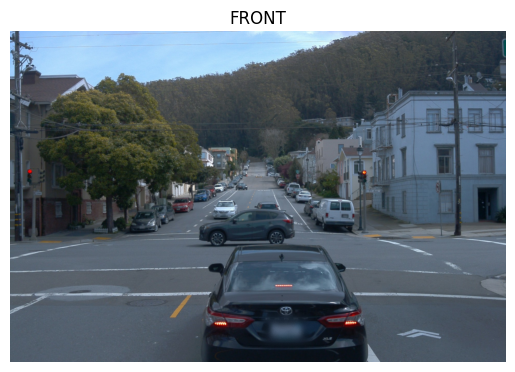

200
Loaded image (457085 bytes) for camera_image.key.camera_name=2 1553628868248879 camera_image.key.camera_name=2
Loaded image (311488 bytes) for camera_image.key.camera_name=4 1553628868248879 camera_image.key.camera_name=4
Loaded image (341577 bytes) for camera_image.key.camera_name=3 1553628868248879 camera_image.key.camera_name=3
Loaded image (194270 bytes) for camera_image.key.camera_name=5 1553628868248879 camera_image.key.camera_name=5
Loaded image (427659 bytes) for camera_image.key.camera_name=1 1553628868348901 camera_image.key.camera_name=1
Loaded image (456835 bytes) for camera_image.key.camera_name=2 1553628868348901 camera_image.key.camera_name=2
Loaded image (311221 bytes) for camera_image.key.camera_name=4 1553628868348901 camera_image.key.camera_name=4
Loaded image (341079 bytes) for camera_image.key.camera_name=3 1553628868348901 camera_image.key.camera_name=3
Loaded image (194208 bytes) for camera_image.key.camera_name=5 1553628868348901 camera_image.key.camera_name

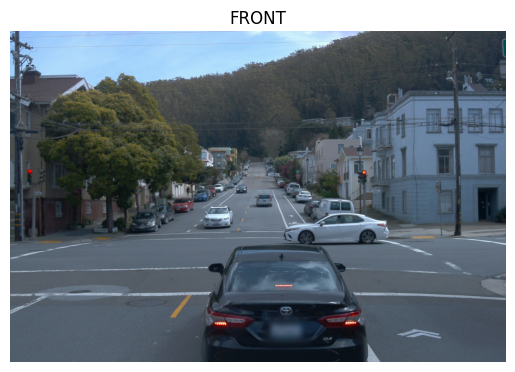

300
Loaded image (456754 bytes) for camera_image.key.camera_name=2 1553628870248899 camera_image.key.camera_name=2
Loaded image (312148 bytes) for camera_image.key.camera_name=4 1553628870248899 camera_image.key.camera_name=4
Loaded image (338774 bytes) for camera_image.key.camera_name=3 1553628870248899 camera_image.key.camera_name=3
Loaded image (194044 bytes) for camera_image.key.camera_name=5 1553628870248899 camera_image.key.camera_name=5
Loaded image (429622 bytes) for camera_image.key.camera_name=1 1553628870348924 camera_image.key.camera_name=1
Loaded image (456603 bytes) for camera_image.key.camera_name=2 1553628870348924 camera_image.key.camera_name=2
Loaded image (312170 bytes) for camera_image.key.camera_name=4 1553628870348924 camera_image.key.camera_name=4
Loaded image (338495 bytes) for camera_image.key.camera_name=3 1553628870348924 camera_image.key.camera_name=3
Loaded image (194470 bytes) for camera_image.key.camera_name=5 1553628870348924 camera_image.key.camera_name

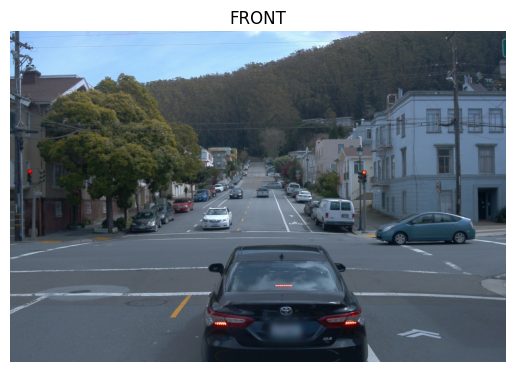

400
Loaded image (457593 bytes) for camera_image.key.camera_name=2 1553628872248975 camera_image.key.camera_name=2
Loaded image (313422 bytes) for camera_image.key.camera_name=4 1553628872248975 camera_image.key.camera_name=4
Loaded image (340909 bytes) for camera_image.key.camera_name=3 1553628872248975 camera_image.key.camera_name=3
Loaded image (194078 bytes) for camera_image.key.camera_name=5 1553628872248975 camera_image.key.camera_name=5
Loaded image (432200 bytes) for camera_image.key.camera_name=1 1553628872348961 camera_image.key.camera_name=1
Loaded image (457331 bytes) for camera_image.key.camera_name=2 1553628872348961 camera_image.key.camera_name=2
Loaded image (313580 bytes) for camera_image.key.camera_name=4 1553628872348961 camera_image.key.camera_name=4
Loaded image (340241 bytes) for camera_image.key.camera_name=3 1553628872348961 camera_image.key.camera_name=3
Loaded image (194418 bytes) for camera_image.key.camera_name=5 1553628872348961 camera_image.key.camera_name

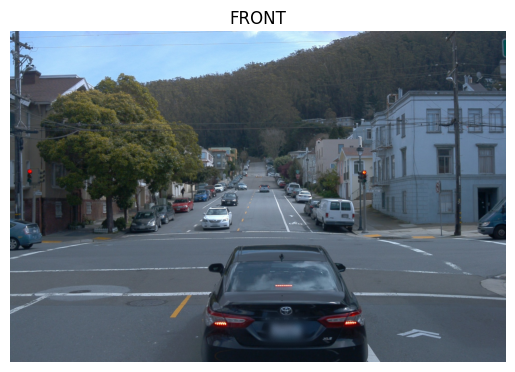

500
Loaded image (457782 bytes) for camera_image.key.camera_name=2 1553628874248951 camera_image.key.camera_name=2
Loaded image (314311 bytes) for camera_image.key.camera_name=4 1553628874248951 camera_image.key.camera_name=4
Loaded image (339241 bytes) for camera_image.key.camera_name=3 1553628874248951 camera_image.key.camera_name=3
Loaded image (194757 bytes) for camera_image.key.camera_name=5 1553628874248951 camera_image.key.camera_name=5
Loaded image (433957 bytes) for camera_image.key.camera_name=1 1553628874348939 camera_image.key.camera_name=1
Loaded image (457310 bytes) for camera_image.key.camera_name=2 1553628874348939 camera_image.key.camera_name=2
Loaded image (314446 bytes) for camera_image.key.camera_name=4 1553628874348939 camera_image.key.camera_name=4
Loaded image (339681 bytes) for camera_image.key.camera_name=3 1553628874348939 camera_image.key.camera_name=3
Loaded image (194762 bytes) for camera_image.key.camera_name=5 1553628874348939 camera_image.key.camera_name

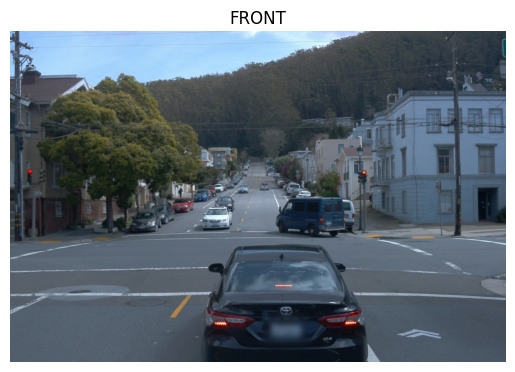

600
Loaded image (456113 bytes) for camera_image.key.camera_name=2 1553628876248899 camera_image.key.camera_name=2
Loaded image (314543 bytes) for camera_image.key.camera_name=4 1553628876248899 camera_image.key.camera_name=4
Loaded image (340981 bytes) for camera_image.key.camera_name=3 1553628876248899 camera_image.key.camera_name=3
Loaded image (194343 bytes) for camera_image.key.camera_name=5 1553628876248899 camera_image.key.camera_name=5
Loaded image (430953 bytes) for camera_image.key.camera_name=1 1553628876348889 camera_image.key.camera_name=1
Loaded image (456406 bytes) for camera_image.key.camera_name=2 1553628876348889 camera_image.key.camera_name=2
Loaded image (315015 bytes) for camera_image.key.camera_name=4 1553628876348889 camera_image.key.camera_name=4
Loaded image (341131 bytes) for camera_image.key.camera_name=3 1553628876348889 camera_image.key.camera_name=3
Loaded image (194525 bytes) for camera_image.key.camera_name=5 1553628876348889 camera_image.key.camera_name

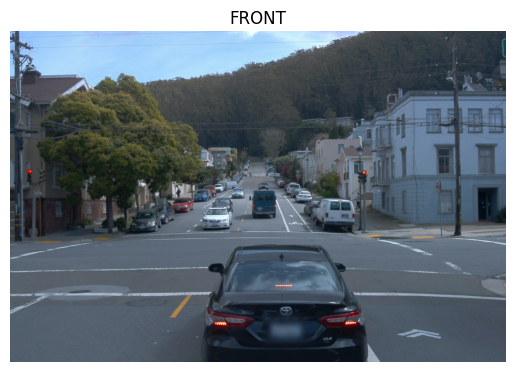

700
Loaded image (456659 bytes) for camera_image.key.camera_name=2 1553628878248901 camera_image.key.camera_name=2
Loaded image (314918 bytes) for camera_image.key.camera_name=4 1553628878248901 camera_image.key.camera_name=4
Loaded image (340357 bytes) for camera_image.key.camera_name=3 1553628878248901 camera_image.key.camera_name=3
Loaded image (194438 bytes) for camera_image.key.camera_name=5 1553628878248901 camera_image.key.camera_name=5
Loaded image (431705 bytes) for camera_image.key.camera_name=1 1553628878348891 camera_image.key.camera_name=1
Loaded image (456528 bytes) for camera_image.key.camera_name=2 1553628878348891 camera_image.key.camera_name=2
Loaded image (314758 bytes) for camera_image.key.camera_name=4 1553628878348891 camera_image.key.camera_name=4
Loaded image (340352 bytes) for camera_image.key.camera_name=3 1553628878348891 camera_image.key.camera_name=3
Loaded image (194671 bytes) for camera_image.key.camera_name=5 1553628878348891 camera_image.key.camera_name

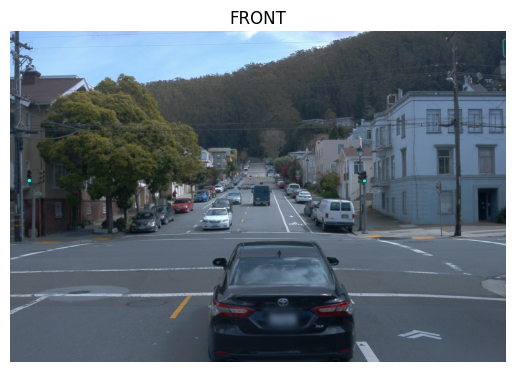

800
Loaded image (453292 bytes) for camera_image.key.camera_name=2 1553628880248841 camera_image.key.camera_name=2
Loaded image (314846 bytes) for camera_image.key.camera_name=4 1553628880248841 camera_image.key.camera_name=4
Loaded image (337384 bytes) for camera_image.key.camera_name=3 1553628880248841 camera_image.key.camera_name=3
Loaded image (193680 bytes) for camera_image.key.camera_name=5 1553628880248841 camera_image.key.camera_name=5
Loaded image (427639 bytes) for camera_image.key.camera_name=1 1553628880348826 camera_image.key.camera_name=1
Loaded image (453105 bytes) for camera_image.key.camera_name=2 1553628880348826 camera_image.key.camera_name=2
Loaded image (315233 bytes) for camera_image.key.camera_name=4 1553628880348826 camera_image.key.camera_name=4
Loaded image (337733 bytes) for camera_image.key.camera_name=3 1553628880348826 camera_image.key.camera_name=3
Loaded image (193953 bytes) for camera_image.key.camera_name=5 1553628880348826 camera_image.key.camera_name

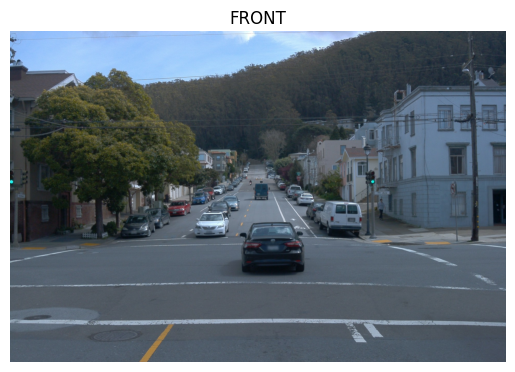

900
Loaded image (439043 bytes) for camera_image.key.camera_name=2 1553628882249087 camera_image.key.camera_name=2
Loaded image (320215 bytes) for camera_image.key.camera_name=4 1553628882249087 camera_image.key.camera_name=4
Loaded image (344773 bytes) for camera_image.key.camera_name=3 1553628882249087 camera_image.key.camera_name=3
Loaded image (192042 bytes) for camera_image.key.camera_name=5 1553628882249087 camera_image.key.camera_name=5
Loaded image (423242 bytes) for camera_image.key.camera_name=1 1553628882349071 camera_image.key.camera_name=1
Loaded image (437747 bytes) for camera_image.key.camera_name=2 1553628882349071 camera_image.key.camera_name=2
Loaded image (318888 bytes) for camera_image.key.camera_name=4 1553628882349071 camera_image.key.camera_name=4
Loaded image (348960 bytes) for camera_image.key.camera_name=3 1553628882349071 camera_image.key.camera_name=3
Loaded image (192191 bytes) for camera_image.key.camera_name=5 1553628882349071 camera_image.key.camera_name

In [47]:
from waymo_open_dataset import dataset_pb2 as open_dataset
import matplotlib.pyplot as plt
import dask.dataframe as dd
import tensorflow as tf
from waymo_open_dataset import v2


camera_left_to_right_order = [open_dataset.CameraName.SIDE_LEFT, #4
                            open_dataset.CameraName.FRONT_LEFT, #2
                            open_dataset.CameraName.FRONT, #1
                            open_dataset.CameraName.FRONT_RIGHT, #3
                            open_dataset.CameraName.SIDE_RIGHT] #5

camera_name_list = {
   1 : "FRONT",
   2 : "FRONT_LEFT",
   3 : "FRONT_RIGHT",
   4 : "SIDE_LEFT",
   5 : "SIDE_RIGHT"
}
camera_name_num = 1

# Path to the directory with all components
dataset_dir = '/media/kaiwenjon/Kevin-linux-dats/waymo/dataset_v2/validation'

context_name = '17065833287841703_2980_000_3000_000'

def read(tag: str) -> dd.DataFrame:
  """Creates a Dask DataFrame for the component specified by its tag."""
  paths = tf.io.gfile.glob(f'{dataset_dir}/{tag}/{context_name}.parquet')
  return dd.read_parquet(paths)


camera_image_df = read('camera_image')
# Filter the images from camera=1
# NOTE: We could also use push down filters while reading the parquet files as well
# Details https://docs.dask.org/en/stable/generated/dask.dataframe.read_parquet.html#dask.dataframe.read_parquet
# camera_image_df = camera_image_df[camera_image_df['key.camera_name'] == camera_name_num]

# camera_box_df = read('camera_box')
# # Inner join the camera_image table with the camera_box table.
# df = camera_image_df.merge(
#     camera_box_df,
#     on=[
#         'key.segment_context_name',
#         'key.frame_timestamp_micros',
#         'key.camera_name',
#     ],
#     how='inner',
# )
for i, (key_values, row) in enumerate(camera_image_df.iterrows()):
    # Create corresponding components from the raw
#     _, row = next(iter(camera_image_df.iterrows()))

    camera_image = v2.CameraImageComponent.from_dict(row)

    print(
            f'Loaded image ({len(camera_image.image)} bytes) for'
            f' {camera_image.key.camera_name=} {camera_image.key.frame_timestamp_micros} {camera_image.key.camera_name=}'
        )
    if(i % 100 == 0):
        plt.imshow(tf.image.decode_jpeg(camera_image.image))
        plt.title(camera_name_list[camera_image.key.camera_name])
        plt.grid(False)
        plt.axis('off')
        plt.show()
        print(i)